In [189]:
from lambeq import BobcatParser, SpacyTokeniser
import torch, numpy, pandas as pd, re

In [190]:
def create_list(num,maxi):
    lst = [0] * maxi
    lst[num] = 1
    return lst

Let us read the files with the sentences, clean them and put the sentences into a new files.

In [191]:
def clean_text(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    text =  ' '.join(text.split())
    #print(text)
    return text

In [192]:
def process_csv_lines(input_file_path, output_file_path):
    """
    Reads a CSV file, processes each line to remove all commas except the last one,
    and writes the processed lines to a new file.
    """
    with open(input_file_path, 'r', encoding='utf-8') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
        for line in input_file:
            if ',' in line:
                parts = line.rsplit(',', 1)  # Split from the right at the last comma
                new_line = parts[0].replace(',', '') # Remove all commas from the first part
            else:
                new_line = line  # If no comma is present, leave the line unchanged
            
            output_file.write(clean_text(new_line)+ ',' + parts[1])



In [193]:
# Process Train dataset 
input_file = "dataset_dim4/train_dataset.csv"
output_file = "dataset_dim4/train_clean_data.csv"
process_csv_lines(input_file,output_file)

In [194]:
# Process Test dataset
input_file = "dataset_dim4/test_dataset.csv"
output_file = "dataset_dim4/test_clean_data.csv"
process_csv_lines(input_file,output_file)

In [195]:
column_names = ["text", "label"]
train_dataset = pd.read_csv("dataset_dim4/train_clean_data.csv", names=column_names).sample(frac = 1, )
test_dataset = pd.read_csv("dataset_dim4/test_clean_data.csv", names=column_names).sample(frac = 1)

In [196]:
train_dataset[:10]

,text,label
116,the library is closed on sundays,2
92,robust security system though complex to navigate,3
43,received what expected,2
125,disappointed by the lack of features that were...,1
138,the app offers many features but consumes too ...,3
49,the book was okay not great,2
134,the products innovative design is impressive b...,3
56,an ordinary experience but pleasant,2
130,the dessert looked enticing but its taste was ...,3
6,truly delightful experience from start to finish,0


In [197]:
test_dataset[:10]

,text,label
23,the quality of the craftsmanship is evident in...,0
25,the softwares intuitive design made it breeze ...,0
19,the application process is unnecessarily compl...,1
20,the workshop exceeded all my expectations with...,0
9,her presentation covers the basics of financia...,2
21,his performance was breathtaking capturing the...,0
2,the meeting is scheduled for pm tomorrow,2
3,the software requires mb of ram to run,2
17,the presentation was disorganized lacking clea...,1
16,service charges were not mentioned upfront lea...,1


In [198]:
from lambeq import SpacyTokeniser

tokeniser = SpacyTokeniser()

train_data = [tokeniser.tokenise_sentence(sent) for sent in train_dataset.iloc[:, 0].to_list()]
train_labels = [create_list(ele,4) for ele in train_dataset.iloc[:, 1].to_list()]
test_data = [tokeniser.tokenise_sentence(sent) for sent in test_dataset.iloc[:, 0].to_list()]
test_labels = [create_list(ele,4) for ele in test_dataset.iloc[:, 1].to_list()]

#train_labels = [[1-x, x] for x in train_dataset.iloc[:, 1].to_list()]
#test_labels = [[1-x, x] for x in test_dataset.iloc[:, 1].to_list()]

## Text 2 Diagram

In [199]:
parser = BobcatParser(root_cats=('NP', 'N'))
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True, tokenised=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True, tokenised=True)

Tagging sentences:   0%|          | 0/35 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/140 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/140 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/10 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/40 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/40 [00:00<?, ?it/s]

In [200]:
print("Number of Train diagrams", len(train_diagrams), "and labels", len(train_labels), "match? ->", len(train_diagrams) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams), "and labels", len(test_labels), "match? ->", len(test_diagrams) == len(test_labels))

Number of Train diagrams 140 and labels 140 match? -> True
Number of Test diagrams 40 and labels 40 match? -> True


In [201]:
train_diagrams_filter = []

for index,diagram in enumerate(train_diagrams):
    if diagram is not None:
        train_diagrams_filter.append(diagram.normal_form())
    else:
        train_labels[index] = None
        
test_diagrams_filter = []

for index,diagram in enumerate(test_diagrams):
    if diagram is not None:
        test_diagrams_filter.append(diagram.normal_form())
    else:
        test_labels[index] = None

In [202]:
def remove_none(ll):
    return [x for x in ll if x is not None]

train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [203]:
print("Number of Train diagrams", len(train_diagrams_filter), "and labels", len(train_labels), "match? ->", len(train_diagrams_filter) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams_filter), "and labels", len(test_labels), "match? ->", len(test_diagrams_filter) == len(test_labels))

Number of Train diagrams 122 and labels 122 match? -> True
Number of Test diagrams 33 and labels 33 match? -> True


View the diagram of a sentence to make sure taht everything is working fine

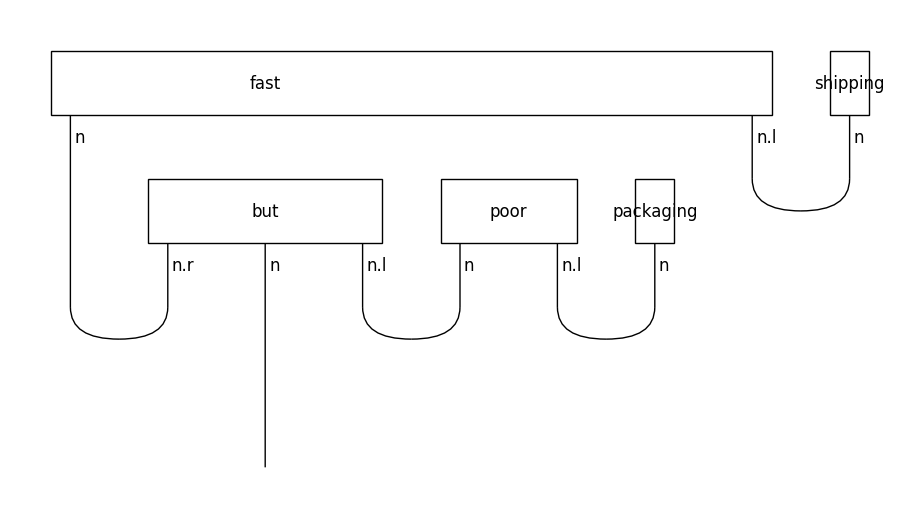

In [204]:
train_diagrams_filter[11].normal_form().draw(figsize=(9, 5), fontsize=12)

## Diagram 2 Circuit

In [205]:
from lambeq import AtomicType, IQPAnsatz, SpiderAnsatz
from lambeq.backend.tensor import Dim

# Define types for the ansatz
noun = AtomicType.NOUN
sentence_type = AtomicType.SENTENCE
prep = AtomicType.PREPOSITIONAL_PHRASE

# Create an ansatz (IQPAnsatz in this example)
ansatz = SpiderAnsatz({prep:Dim(4), noun: Dim(4), sentence_type: Dim(4)})

train_circuits = []
test_circuits =  []

for index, diag in enumerate(train_diagrams_filter):
    try:
        train_circuits.append(ansatz(diag))
    except Exception as e:
        print("Problem with Train diagram",index, "-> sentence is:", train_dataset.iloc[index,0])
        train_labels[index] = None
        print(e)

for index,diag in enumerate(test_diagrams_filter):
    try:
        test_circuits.append(ansatz(diag))
    except Exception as e:
        print("Problem with Test diagram",index, "-> sentence is:", test_dataset.iloc[index,0])
        test_labels[index] = None
        #print(e)



#train_circuits[0].draw(figsize=(9, 10))

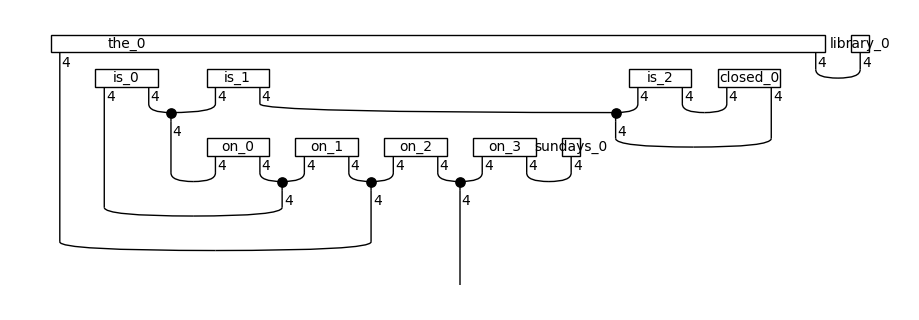

In [206]:
train_circuits[0].draw(figsize=(9, 3))

In [207]:
train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [208]:
print("Number of Train circuits", len(train_circuits), "and labels", len(train_labels), "match? ->", len(train_circuits) == len(train_labels))
print("Number of Test circuits", len(test_circuits), "and labels", len(test_labels), "match? ->", len(test_circuits) == len(test_labels))

Number of Train circuits 122 and labels 122 match? -> True
Number of Test circuits 33 and labels 33 match? -> True


In [209]:
"""
train_diagrams_filter[7].draw(figsize=(9, 1.5))
train_diagrams_filter[43].draw()
train_diagrams_filter[51].draw()
"""

'\ntrain_diagrams_filter[7].draw(figsize=(9, 1.5))\ntrain_diagrams_filter[43].draw()\ntrain_diagrams_filter[51].draw()\n'

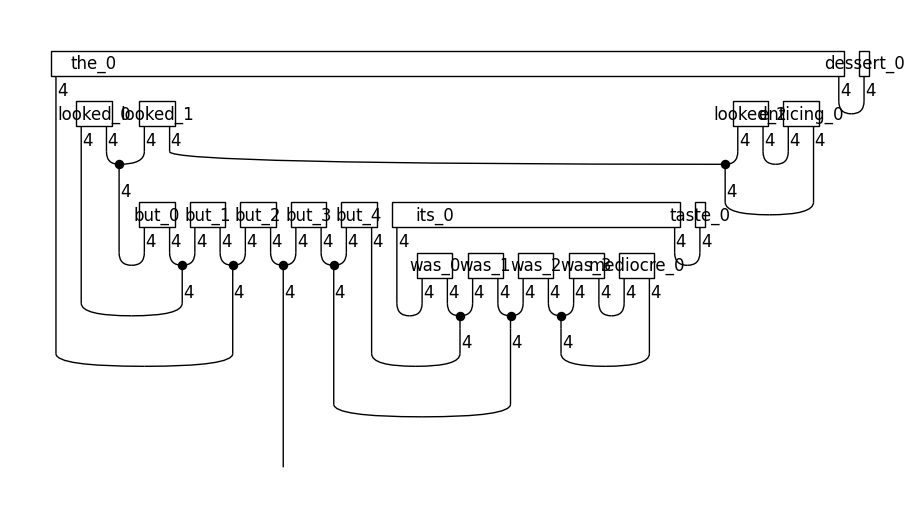

In [210]:
train_circuits[5].draw(figsize=(9, 5), fontsize=12)

## Training

In [215]:
import numpy as np

acc = lambda y_hat, y: np.sum(np.round(y_hat.detach().numpy()) == y) / len(y)/2

eval_metrics = {"acc": acc}

In [216]:
BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 0.03


In [217]:
from lambeq import PytorchModel

all_circuits = train_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

In [218]:
from lambeq import PytorchTrainer, SPSAOptimizer
from lambeq import BinaryCrossEntropyLoss

bce = BinaryCrossEntropyLoss()

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text')

In [219]:
from lambeq import Dataset

new_train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)

new_test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [220]:
trainer.fit(new_train_dataset, new_test_dataset, eval_interval=1, log_interval=5)

Epoch 5:   train/loss: 0.5135   valid/loss: 0.7097   train/acc: 0.0000   valid/acc: 0.0000
Epoch 10:  train/loss: 0.0995   valid/loss: 1.2858   train/acc: 0.0000   valid/acc: 0.0000
Epoch 15:  train/loss: 0.0000   valid/loss: 2.1518   train/acc: 0.0000   valid/acc: 0.0000
Epoch 20:  train/loss: 0.0001   valid/loss: 2.8178   train/acc: 0.0000   valid/acc: 0.0000
Epoch 25:  train/loss: 0.0000   valid/loss: 3.5119   train/acc: 0.0000   valid/acc: 0.0000
Epoch 30:  train/loss: 0.0000   valid/loss: 2.6283   train/acc: 0.0000   valid/acc: 0.0000

Training completed!


In [159]:
print(acc(model(test_circuits), test_labels))

0.8181818181818182


Test accuracy: 0.0


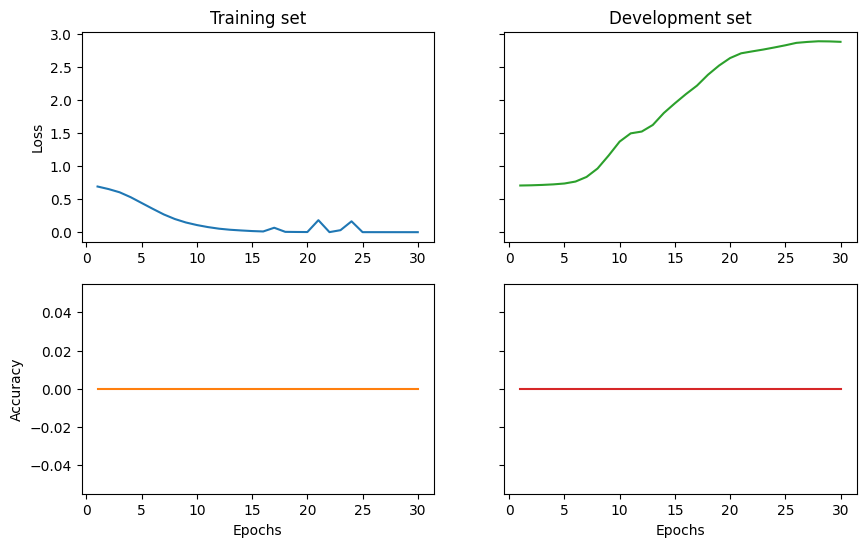

In [160]:
import matplotlib.pyplot as plt
import numpy as np

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
test_acc = acc(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())